# Automating car driving using CNNs
[Link to reference research paper](https://developer.nvidia.com/blog/deep-learning-self-driving-cars/)

Some call it a technical marvel. Some people call it a frenzy. Autonomous vehicles are constantly in the headlines. These self-driving cars, which are designed to carry people from point A to point B without the need for human involvement, are projected to boost mobility, reduce traffic congestion and fuel consumption, and create safer highways.

> ### The DAVE-2 System
> 
> It relies on the three cameras that are mounted behind the windshield of the data-acquisition car, and timestamped video from the cameras is captured simultaneously with the steering angle applied by the human driver. The steering command is obtained by tapping into the vehicle’s Controller Area Network (CAN) bus. In order to make our system independent of the car geometry, we represent the steering command as 1/r, where r is the turning radius in meters. We use 1/r instead of r to prevent a singularity when driving straight (the turning radius for driving straight is infinity). 1/r smoothly transitions through zero from left turns (negative values) to right turns (positive values).

Model used is based on 
<br>
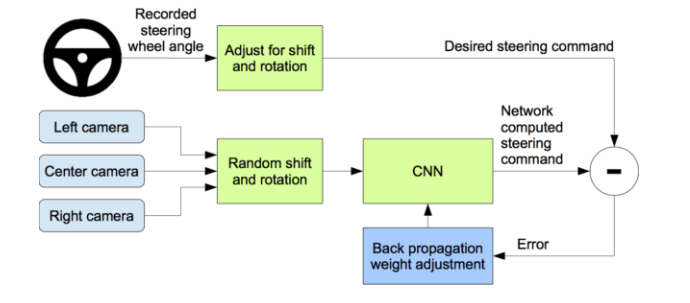


In [1]:
import os
import time
import itertools
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
tqdm.monitor_interval = 0
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from matplotlib import pyplot as plt
import cv2
import matplotlib.image as mpimg
import pandas as pd
# !pip install tensorboard-logger
# from tensorboard_logger import configure, log_value
from torch.utils.data import Dataset
import csv

Lets start by importing the Required modules
this version of code uses *Pytorch with cuda* to utilise the GPU

In [2]:
class CNN_Model(nn.Module):

    def __init__(self):
        super().__init__()

        self.elu = nn.ELU()
        self.dropout = nn.Dropout()

        self.conv_0 = nn.Conv2d(3, 24, 5, stride=2)
        self.conv_1 = nn.Conv2d(24, 36, kernel_size=5, stride=2)
        self.conv_2 = nn.Conv2d(36, 48, kernel_size=5, stride=2) #384 kernels, size 3x3
        self.conv_3 = nn.Conv2d(48, 64, kernel_size=3) # 384 kernels size 3x3
        self.conv_4 = nn.Conv2d(64, 64, kernel_size=3) # 256 kernels, size 3x3

        self.fc0 = nn.Linear(1152, 100)
        self.fc1 = nn.Linear(100,50)
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, input):
        input = input/127.5-1.0
        input = self.elu(self.conv_0(input))
        input = self.elu(self.conv_1(input))
        input = self.elu(self.conv_2(input))
        input = self.elu(self.conv_3(input))
        input = self.elu(self.conv_4(input))
        input = self.dropout(input)

        input = input.flatten()
        input = self.elu(self.fc0(input))
        input = self.elu(self.fc1(input))
        input = self.elu(self.fc2(input))
        input = self.fc3(input)

        return input


In [3]:
model = CNN_Model()

if torch.cuda.is_available():
        model = model.cuda()

model

CNN_Model(
  (elu): ELU(alpha=1.0)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv_0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (conv_1): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (conv_2): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (conv_3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc0): Linear(in_features=1152, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

In [4]:
class Features(Dataset):
    def __init__(self, path_to_csv):
        path_to_csv = os.path.join(path_to_csv, 'driving_log.csv')
        print(path_to_csv)
        self.csv_data = self.load_csv_file(path_to_csv)

    def load_csv_file(self, path_to_csv):
        data = []
        with open(path_to_csv, 'r') as csvfile:
            data_reader = csv.reader(csvfile, delimiter=',')
            for row in data_reader:
                data.append(row)

        return data

    def get_csv_data(self):
        return self.csv_data

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self,i):
        data_entry = self.csv_data[i]

        to_return = {
            'img_center_pth': data_entry[0],
            'img_left_pth': data_entry[1],
            'img_right_pth': data_entry[2],
            'steering_angle': data_entry[3],
            'throttle': data_entry[4],
            'brake': data_entry[5],
            'speed': data_entry[6]
        }

        return to_return


In [5]:
 dataset = Features("../input/car-simulator-dataset/")

../input/car-simulator-dataset/driving_log.csv


We need to split the data into training and validation sets

In [6]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data , val_data = torch.utils.data.dataset.random_split(dataset,[train_size,val_size])


In [7]:
print(train_data)

## **Augmentation**
After selecting the final set of frames, we augment the data by adding artificial shifts and rotations to teach the network how to recover from a poor position or orientation. The magnitude of these perturbations is chosen randomly from a normal distribution. The distribution has zero mean, and the standard deviation is twice the standard deviation that we measured with human drivers. Artificially augmenting the data does add undesirable artifacts as the magnitude increases (as mentioned previously).

In [8]:
#template used from https://github.com/naokishibuya/car-behavioral-cloning/blob/master/utils.py

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)


def load_image(data_dir, image_file):
    """
    Load RGB images from a file
    """
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))


def crop(image):
    """
    Crop the image (removing the sky at the top and the car front at the bottom)
    """
    return image[60:-25, :, :] # remove the sky and the car front


def resize(image):
    """
    Resize the image to the input shape used by the network model
    """
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)


def rgb2yuv(image):
    """
    Convert the image from RGB to YUV (This is what the NVIDIA model does)
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)


def preprocess(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image


def choose_image(steering_angle):
    """
    Randomly choose an image from the center, left or right, and adjust
    the steering angle.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return "img_left_pth", float(steering_angle) + 0.2
    elif choice == 1:
        return "img_right_pth", float(steering_angle) - 0.2
    return "img_center_pth", float(steering_angle)


def random_flip(image, steering_angle):
    """
    Randomly flipt the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle


def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle


def random_shadow(image):
    """
    Generates and adds random shadow
    """
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line:
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[np.where((ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0)] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)


def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def augument(data_dir, center, left, right, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    image, steering_angle = choose_image(data_dir, center, left, right, steering_angle)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_translate(image, steering_angle, range_x, range_y)
    image = random_shadow(image)
    image = random_brightness(image)
    return image, steering_angle


def batch_generator(data_dir, image_paths, steering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            # argumentation
            if is_training and np.random.rand() < 0.6:
                image, steering_angle = augument(data_dir, center, left, right, steering_angle)
            else:
                image = load_image(data_dir, center)
            # add the image and steering angle to the batch
            images[i] = preprocess(image)
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        yield images, steers

defined a function to rectify the image path in data set

In [9]:
def rectify(data,img_pth):
    val = data[img_pth].split("\\")[-1]
    val = ("../input/car-simulator-dataset/img/IMG/"+val)
    data[img_pth] = val

In [10]:
def eval_model(model,dataset,num_samples):
    model.eval()
    criterion = nn.MSELoss()
    step = 0
    val_loss = 0
    count = 0
    sampler = RandomSampler(dataset)
    torch.manual_seed(0)
    for sample_id in tqdm(sampler):
        if step==num_samples:
            break

        data = dataset[sample_id]
        img_pth, label = choose_image(data['steering_angle'])
        rectify(data,img_pth)
        
        img = cv2.imread(data[img_pth])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = preprocess(img)
        img, label = random_flip(img, label)
        img, label = random_translate(img, label, 100, 10)
        img = random_shadow(img)
        img = random_brightness(img)
        img = Variable(torch.cuda.FloatTensor([img]))
        img = img.permute(0,3,1,2)
        label = np.array([label]).astype(float)
        label = Variable(torch.cuda.FloatTensor(label))

        out_vec = model(img)

        loss = criterion(out_vec,label)

        batch_size = 4
        val_loss += loss.data.item()
        count += batch_size
        step += 1

    val_loss = val_loss / float(count)
    return val_loss


## Model Training
The model saves the file after every 5000 
so that if GPU crashes we wont lose the models trained so far

In [11]:
model.train()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

model_dir = "./models/"
step = 0 
imgs_per_batch = 40
optimizer.zero_grad()
for epoch in range(10):
    sampler = RandomSampler(train_data, replacement=True, num_samples=20000)
    for i, sample_id in enumerate(sampler):
        data = train_data[sample_id]
        
        label = data["steering_angle"]
        img_pth, label = choose_image(label)
#         print("img_pth" ,img_pth)
#         print("data[pth]",data[img_pth])
        rectify(data,img_pth)
#         print("img_pth" ,img_pth)
#         print("data[pth]",data[img_pth])
        img = cv2.imread(data[img_pth])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = preprocess(img)
        img, label = random_flip(img, label)
        img, label = random_translate(img, label, 100, 10)
        img = random_shadow(img)
        img = random_brightness(img)
        img = Variable(torch.cuda.FloatTensor([img]))
        label = np.array([label]).astype(float)
        label = Variable(torch.cuda.FloatTensor(label))
        img = img.permute(0,3,1,2)
        
        out_vec = model(img)
        loss = criterion(out_vec,label)

        loss.backward()
        if step%imgs_per_batch==0:
            optimizer.step()
            optimizer.zero_grad()


        if step%100==0:
            log_str = \
                'Epoch: {} | Iter: {} | Step: {} | ' + \
                'Train Loss: {:.8f} |'
            log_str = log_str.format(
                epoch,
                i,
                step,
                loss.item())
            print(log_str)

#         if step%100==0:
#             log_value('train_loss',loss.item(),step)

        if step%5000==0:
            val_loss = eval_model(model,val_data, num_samples=400)
#             log_value('val_loss',val_loss,step)
            log_str = \
                'Epoch: {} | Iter: {} | Step: {} | Val Loss: {:.8f}'
            log_str = log_str.format(
                epoch,
                i,
                step,
                val_loss)
            print(log_str)
            model.train()

        if step%5000==0:
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)

            model_pth = os.path.join(
                model_dir,
                'model_{}'.format(step))
            torch.save(
                model.state_dict(),
                model_pth)

        step += 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:207.)


Epoch: 0 | Iter: 0 | Step: 0 | Train Loss: 0.01387499 |


  4%|▍         | 400/9717 [00:09<03:51, 40.23it/s]


Epoch: 0 | Iter: 0 | Step: 0 | Val Loss: 0.02626854
Epoch: 0 | Iter: 100 | Step: 100 | Train Loss: 0.05328948 |
Epoch: 0 | Iter: 200 | Step: 200 | Train Loss: 0.00243725 |
Epoch: 0 | Iter: 300 | Step: 300 | Train Loss: 0.00855983 |
Epoch: 0 | Iter: 400 | Step: 400 | Train Loss: 0.03181834 |
Epoch: 0 | Iter: 500 | Step: 500 | Train Loss: 0.00558425 |
Epoch: 0 | Iter: 600 | Step: 600 | Train Loss: 0.00276919 |
Epoch: 0 | Iter: 700 | Step: 700 | Train Loss: 0.08707961 |
Epoch: 0 | Iter: 800 | Step: 800 | Train Loss: 0.11517500 |
Epoch: 0 | Iter: 900 | Step: 900 | Train Loss: 0.00115327 |
Epoch: 0 | Iter: 1000 | Step: 1000 | Train Loss: 0.10835119 |
Epoch: 0 | Iter: 1100 | Step: 1100 | Train Loss: 0.02124577 |
Epoch: 0 | Iter: 1200 | Step: 1200 | Train Loss: 0.00291905 |
Epoch: 0 | Iter: 1300 | Step: 1300 | Train Loss: 0.00238849 |
Epoch: 0 | Iter: 1400 | Step: 1400 | Train Loss: 0.13998096 |
Epoch: 0 | Iter: 1500 | Step: 1500 | Train Loss: 0.12938750 |
Epoch: 0 | Iter: 1600 | Step: 1600 |

  4%|▍         | 400/9717 [00:09<03:47, 40.91it/s]


Epoch: 0 | Iter: 5000 | Step: 5000 | Val Loss: 0.02219207
Epoch: 0 | Iter: 5100 | Step: 5100 | Train Loss: 0.03013483 |
Epoch: 0 | Iter: 5200 | Step: 5200 | Train Loss: 0.05486815 |
Epoch: 0 | Iter: 5300 | Step: 5300 | Train Loss: 0.00100160 |
Epoch: 0 | Iter: 5400 | Step: 5400 | Train Loss: 0.00593287 |
Epoch: 0 | Iter: 5500 | Step: 5500 | Train Loss: 0.02824558 |
Epoch: 0 | Iter: 5600 | Step: 5600 | Train Loss: 0.00001944 |
Epoch: 0 | Iter: 5700 | Step: 5700 | Train Loss: 0.04061214 |
Epoch: 0 | Iter: 5800 | Step: 5800 | Train Loss: 0.05195013 |
Epoch: 0 | Iter: 5900 | Step: 5900 | Train Loss: 0.02007226 |
Epoch: 0 | Iter: 6000 | Step: 6000 | Train Loss: 0.03741752 |
Epoch: 0 | Iter: 6100 | Step: 6100 | Train Loss: 0.00191617 |
Epoch: 0 | Iter: 6200 | Step: 6200 | Train Loss: 0.05777198 |
Epoch: 0 | Iter: 6300 | Step: 6300 | Train Loss: 0.17270292 |
Epoch: 0 | Iter: 6400 | Step: 6400 | Train Loss: 0.02666191 |
Epoch: 0 | Iter: 6500 | Step: 6500 | Train Loss: 0.00156973 |
Epoch: 0 | I

  4%|▍         | 400/9717 [00:10<03:59, 38.97it/s]


Epoch: 0 | Iter: 10000 | Step: 10000 | Val Loss: 0.02554410
Epoch: 0 | Iter: 10100 | Step: 10100 | Train Loss: 0.03154308 |
Epoch: 0 | Iter: 10200 | Step: 10200 | Train Loss: 0.03267326 |
Epoch: 0 | Iter: 10300 | Step: 10300 | Train Loss: 0.65627867 |
Epoch: 0 | Iter: 10400 | Step: 10400 | Train Loss: 0.00010877 |
Epoch: 0 | Iter: 10500 | Step: 10500 | Train Loss: 0.03203322 |
Epoch: 0 | Iter: 10600 | Step: 10600 | Train Loss: 0.00000352 |
Epoch: 0 | Iter: 10700 | Step: 10700 | Train Loss: 0.04170057 |
Epoch: 0 | Iter: 10800 | Step: 10800 | Train Loss: 0.02618948 |
Epoch: 0 | Iter: 10900 | Step: 10900 | Train Loss: 0.03970001 |
Epoch: 0 | Iter: 11000 | Step: 11000 | Train Loss: 0.00445525 |
Epoch: 0 | Iter: 11100 | Step: 11100 | Train Loss: 0.02824979 |
Epoch: 0 | Iter: 11200 | Step: 11200 | Train Loss: 0.03189955 |
Epoch: 0 | Iter: 11300 | Step: 11300 | Train Loss: 0.00064244 |
Epoch: 0 | Iter: 11400 | Step: 11400 | Train Loss: 0.04730679 |
Epoch: 0 | Iter: 11500 | Step: 11500 | Train

  4%|▍         | 400/9717 [00:09<03:38, 42.71it/s]


Epoch: 0 | Iter: 15000 | Step: 15000 | Val Loss: 0.02652589
Epoch: 0 | Iter: 15100 | Step: 15100 | Train Loss: 0.00251016 |
Epoch: 0 | Iter: 15200 | Step: 15200 | Train Loss: 0.03953616 |
Epoch: 0 | Iter: 15300 | Step: 15300 | Train Loss: 0.00340441 |
Epoch: 0 | Iter: 15400 | Step: 15400 | Train Loss: 0.20997928 |
Epoch: 0 | Iter: 15500 | Step: 15500 | Train Loss: 0.00062004 |
Epoch: 0 | Iter: 15600 | Step: 15600 | Train Loss: 0.04667440 |
Epoch: 0 | Iter: 15700 | Step: 15700 | Train Loss: 0.00887914 |
Epoch: 0 | Iter: 15800 | Step: 15800 | Train Loss: 0.03737038 |
Epoch: 0 | Iter: 15900 | Step: 15900 | Train Loss: 0.00001665 |
Epoch: 0 | Iter: 16000 | Step: 16000 | Train Loss: 0.06755079 |
Epoch: 0 | Iter: 16100 | Step: 16100 | Train Loss: 0.00117045 |
Epoch: 0 | Iter: 16200 | Step: 16200 | Train Loss: 0.00528002 |
Epoch: 0 | Iter: 16300 | Step: 16300 | Train Loss: 0.00107412 |
Epoch: 0 | Iter: 16400 | Step: 16400 | Train Loss: 0.04777538 |
Epoch: 0 | Iter: 16500 | Step: 16500 | Train

  4%|▍         | 400/9717 [00:09<03:37, 42.81it/s]


Epoch: 1 | Iter: 0 | Step: 20000 | Val Loss: 0.02232528
Epoch: 1 | Iter: 100 | Step: 20100 | Train Loss: 0.00021627 |
Epoch: 1 | Iter: 200 | Step: 20200 | Train Loss: 0.02598961 |
Epoch: 1 | Iter: 300 | Step: 20300 | Train Loss: 0.00379238 |
Epoch: 1 | Iter: 400 | Step: 20400 | Train Loss: 0.05331425 |
Epoch: 1 | Iter: 500 | Step: 20500 | Train Loss: 0.04972436 |
Epoch: 1 | Iter: 600 | Step: 20600 | Train Loss: 0.09775529 |
Epoch: 1 | Iter: 700 | Step: 20700 | Train Loss: 0.05171911 |
Epoch: 1 | Iter: 800 | Step: 20800 | Train Loss: 0.04160829 |
Epoch: 1 | Iter: 900 | Step: 20900 | Train Loss: 0.04111102 |
Epoch: 1 | Iter: 1000 | Step: 21000 | Train Loss: 0.00001204 |
Epoch: 1 | Iter: 1100 | Step: 21100 | Train Loss: 0.03849751 |
Epoch: 1 | Iter: 1200 | Step: 21200 | Train Loss: 0.00218677 |
Epoch: 1 | Iter: 1300 | Step: 21300 | Train Loss: 0.00094071 |
Epoch: 1 | Iter: 1400 | Step: 21400 | Train Loss: 0.00026936 |
Epoch: 1 | Iter: 1500 | Step: 21500 | Train Loss: 0.08379629 |
Epoch: 1

  4%|▍         | 400/9717 [00:08<03:23, 45.80it/s]


Epoch: 1 | Iter: 5000 | Step: 25000 | Val Loss: 0.02494576
Epoch: 1 | Iter: 5100 | Step: 25100 | Train Loss: 0.05287201 |
Epoch: 1 | Iter: 5200 | Step: 25200 | Train Loss: 0.00264148 |
Epoch: 1 | Iter: 5300 | Step: 25300 | Train Loss: 0.06691984 |
Epoch: 1 | Iter: 5400 | Step: 25400 | Train Loss: 0.00439253 |
Epoch: 1 | Iter: 5500 | Step: 25500 | Train Loss: 0.01886993 |
Epoch: 1 | Iter: 5600 | Step: 25600 | Train Loss: 0.66470104 |
Epoch: 1 | Iter: 5700 | Step: 25700 | Train Loss: 0.02279209 |
Epoch: 1 | Iter: 5800 | Step: 25800 | Train Loss: 0.04966805 |
Epoch: 1 | Iter: 5900 | Step: 25900 | Train Loss: 0.04462213 |
Epoch: 1 | Iter: 6000 | Step: 26000 | Train Loss: 0.05197810 |
Epoch: 1 | Iter: 6100 | Step: 26100 | Train Loss: 0.02811819 |
Epoch: 1 | Iter: 6200 | Step: 26200 | Train Loss: 0.07229345 |
Epoch: 1 | Iter: 6300 | Step: 26300 | Train Loss: 0.07266396 |
Epoch: 1 | Iter: 6400 | Step: 26400 | Train Loss: 0.00118320 |
Epoch: 1 | Iter: 6500 | Step: 26500 | Train Loss: 0.0042478

  4%|▍         | 400/9717 [00:08<03:28, 44.65it/s]


Epoch: 1 | Iter: 10000 | Step: 30000 | Val Loss: 0.02481445
Epoch: 1 | Iter: 10100 | Step: 30100 | Train Loss: 0.00025612 |
Epoch: 1 | Iter: 10200 | Step: 30200 | Train Loss: 0.05348377 |
Epoch: 1 | Iter: 10300 | Step: 30300 | Train Loss: 0.02800210 |
Epoch: 1 | Iter: 10400 | Step: 30400 | Train Loss: 0.32411754 |
Epoch: 1 | Iter: 10500 | Step: 30500 | Train Loss: 0.04094406 |
Epoch: 1 | Iter: 10600 | Step: 30600 | Train Loss: 0.02919989 |
Epoch: 1 | Iter: 10700 | Step: 30700 | Train Loss: 0.00002491 |
Epoch: 1 | Iter: 10800 | Step: 30800 | Train Loss: 0.00686182 |
Epoch: 1 | Iter: 10900 | Step: 30900 | Train Loss: 0.13796178 |
Epoch: 1 | Iter: 11000 | Step: 31000 | Train Loss: 0.00036292 |
Epoch: 1 | Iter: 11100 | Step: 31100 | Train Loss: 0.39557031 |
Epoch: 1 | Iter: 11200 | Step: 31200 | Train Loss: 0.53308070 |
Epoch: 1 | Iter: 11300 | Step: 31300 | Train Loss: 0.06446958 |
Epoch: 1 | Iter: 11400 | Step: 31400 | Train Loss: 0.03494390 |
Epoch: 1 | Iter: 11500 | Step: 31500 | Train

  4%|▍         | 400/9717 [00:09<03:32, 43.84it/s]


Epoch: 1 | Iter: 15000 | Step: 35000 | Val Loss: 0.02541756
Epoch: 1 | Iter: 15100 | Step: 35100 | Train Loss: 0.00718114 |
Epoch: 1 | Iter: 15200 | Step: 35200 | Train Loss: 0.01811360 |
Epoch: 1 | Iter: 15300 | Step: 35300 | Train Loss: 0.00048973 |
Epoch: 1 | Iter: 15400 | Step: 35400 | Train Loss: 0.00063977 |
Epoch: 1 | Iter: 15500 | Step: 35500 | Train Loss: 0.00266702 |
Epoch: 1 | Iter: 15600 | Step: 35600 | Train Loss: 0.03803430 |
Epoch: 1 | Iter: 15700 | Step: 35700 | Train Loss: 0.00284557 |
Epoch: 1 | Iter: 15800 | Step: 35800 | Train Loss: 0.02082249 |
Epoch: 1 | Iter: 15900 | Step: 35900 | Train Loss: 0.00165112 |
Epoch: 1 | Iter: 16000 | Step: 36000 | Train Loss: 0.00022705 |
Epoch: 1 | Iter: 16100 | Step: 36100 | Train Loss: 0.07370972 |
Epoch: 1 | Iter: 16200 | Step: 36200 | Train Loss: 0.00009675 |
Epoch: 1 | Iter: 16300 | Step: 36300 | Train Loss: 0.06373876 |
Epoch: 1 | Iter: 16400 | Step: 36400 | Train Loss: 0.00089824 |
Epoch: 1 | Iter: 16500 | Step: 36500 | Train

  4%|▍         | 400/9717 [00:08<03:19, 46.64it/s]


Epoch: 2 | Iter: 0 | Step: 40000 | Val Loss: 0.02670077
Epoch: 2 | Iter: 100 | Step: 40100 | Train Loss: 0.01752030 |
Epoch: 2 | Iter: 200 | Step: 40200 | Train Loss: 0.02115411 |
Epoch: 2 | Iter: 300 | Step: 40300 | Train Loss: 0.04711604 |
Epoch: 2 | Iter: 400 | Step: 40400 | Train Loss: 0.02487163 |
Epoch: 2 | Iter: 500 | Step: 40500 | Train Loss: 0.07682990 |
Epoch: 2 | Iter: 600 | Step: 40600 | Train Loss: 0.01235104 |
Epoch: 2 | Iter: 700 | Step: 40700 | Train Loss: 0.03778712 |
Epoch: 2 | Iter: 800 | Step: 40800 | Train Loss: 0.00158844 |
Epoch: 2 | Iter: 900 | Step: 40900 | Train Loss: 0.00063832 |
Epoch: 2 | Iter: 1000 | Step: 41000 | Train Loss: 0.00049582 |
Epoch: 2 | Iter: 1100 | Step: 41100 | Train Loss: 0.00095954 |
Epoch: 2 | Iter: 1200 | Step: 41200 | Train Loss: 0.04842978 |
Epoch: 2 | Iter: 1300 | Step: 41300 | Train Loss: 0.00000322 |
Epoch: 2 | Iter: 1400 | Step: 41400 | Train Loss: 0.04463355 |
Epoch: 2 | Iter: 1500 | Step: 41500 | Train Loss: 0.00475270 |
Epoch: 2

  4%|▍         | 400/9717 [00:08<03:27, 44.96it/s]


Epoch: 2 | Iter: 5000 | Step: 45000 | Val Loss: 0.02366420
Epoch: 2 | Iter: 5100 | Step: 45100 | Train Loss: 0.03940463 |
Epoch: 2 | Iter: 5200 | Step: 45200 | Train Loss: 0.00118048 |
Epoch: 2 | Iter: 5300 | Step: 45300 | Train Loss: 0.02085676 |
Epoch: 2 | Iter: 5400 | Step: 45400 | Train Loss: 0.05328076 |
Epoch: 2 | Iter: 5500 | Step: 45500 | Train Loss: 0.04418397 |
Epoch: 2 | Iter: 5600 | Step: 45600 | Train Loss: 0.73278683 |
Epoch: 2 | Iter: 5700 | Step: 45700 | Train Loss: 0.02113064 |
Epoch: 2 | Iter: 5800 | Step: 45800 | Train Loss: 0.02845131 |
Epoch: 2 | Iter: 5900 | Step: 45900 | Train Loss: 0.04499878 |
Epoch: 2 | Iter: 6000 | Step: 46000 | Train Loss: 0.07122887 |
Epoch: 2 | Iter: 6100 | Step: 46100 | Train Loss: 0.00822797 |
Epoch: 2 | Iter: 6200 | Step: 46200 | Train Loss: 0.06520497 |
Epoch: 2 | Iter: 6300 | Step: 46300 | Train Loss: 0.02175295 |
Epoch: 2 | Iter: 6400 | Step: 46400 | Train Loss: 0.03524933 |
Epoch: 2 | Iter: 6500 | Step: 46500 | Train Loss: 0.0041993

  4%|▍         | 400/9717 [00:08<03:17, 47.27it/s]


Epoch: 2 | Iter: 10000 | Step: 50000 | Val Loss: 0.02351099
Epoch: 2 | Iter: 10100 | Step: 50100 | Train Loss: 0.01301706 |
Epoch: 2 | Iter: 10200 | Step: 50200 | Train Loss: 0.00003373 |
Epoch: 2 | Iter: 10300 | Step: 50300 | Train Loss: 0.03056487 |
Epoch: 2 | Iter: 10400 | Step: 50400 | Train Loss: 0.36492354 |
Epoch: 2 | Iter: 10500 | Step: 50500 | Train Loss: 0.02632892 |
Epoch: 2 | Iter: 10600 | Step: 50600 | Train Loss: 0.01139277 |
Epoch: 2 | Iter: 10700 | Step: 50700 | Train Loss: 0.01159056 |
Epoch: 2 | Iter: 10800 | Step: 50800 | Train Loss: 0.05324670 |
Epoch: 2 | Iter: 10900 | Step: 50900 | Train Loss: 0.49771830 |
Epoch: 2 | Iter: 11000 | Step: 51000 | Train Loss: 0.10951795 |
Epoch: 2 | Iter: 11100 | Step: 51100 | Train Loss: 0.17521700 |
Epoch: 2 | Iter: 11200 | Step: 51200 | Train Loss: 0.50711286 |
Epoch: 2 | Iter: 11300 | Step: 51300 | Train Loss: 0.06480640 |
Epoch: 2 | Iter: 11400 | Step: 51400 | Train Loss: 0.07183496 |
Epoch: 2 | Iter: 11500 | Step: 51500 | Train

  4%|▍         | 400/9717 [00:09<03:35, 43.21it/s]


Epoch: 2 | Iter: 15000 | Step: 55000 | Val Loss: 0.02305634
Epoch: 2 | Iter: 15100 | Step: 55100 | Train Loss: 0.04716038 |
Epoch: 2 | Iter: 15200 | Step: 55200 | Train Loss: 0.03410321 |
Epoch: 2 | Iter: 15300 | Step: 55300 | Train Loss: 0.02900368 |
Epoch: 2 | Iter: 15400 | Step: 55400 | Train Loss: 0.01704587 |
Epoch: 2 | Iter: 15500 | Step: 55500 | Train Loss: 0.03572469 |
Epoch: 2 | Iter: 15600 | Step: 55600 | Train Loss: 0.04097014 |
Epoch: 2 | Iter: 15700 | Step: 55700 | Train Loss: 0.00497267 |
Epoch: 2 | Iter: 15800 | Step: 55800 | Train Loss: 0.00386415 |
Epoch: 2 | Iter: 15900 | Step: 55900 | Train Loss: 0.03789058 |
Epoch: 2 | Iter: 16000 | Step: 56000 | Train Loss: 0.03133382 |
Epoch: 2 | Iter: 16100 | Step: 56100 | Train Loss: 0.06827624 |
Epoch: 2 | Iter: 16200 | Step: 56200 | Train Loss: 0.04675393 |
Epoch: 2 | Iter: 16300 | Step: 56300 | Train Loss: 0.00025375 |
Epoch: 2 | Iter: 16400 | Step: 56400 | Train Loss: 0.04731617 |
Epoch: 2 | Iter: 16500 | Step: 56500 | Train

  4%|▍         | 400/9717 [00:09<03:35, 43.15it/s]


Epoch: 3 | Iter: 0 | Step: 60000 | Val Loss: 0.02305189
Epoch: 3 | Iter: 100 | Step: 60100 | Train Loss: 0.00000772 |
Epoch: 3 | Iter: 200 | Step: 60200 | Train Loss: 0.00542315 |
Epoch: 3 | Iter: 300 | Step: 60300 | Train Loss: 0.03380617 |
Epoch: 3 | Iter: 400 | Step: 60400 | Train Loss: 0.03833790 |
Epoch: 3 | Iter: 500 | Step: 60500 | Train Loss: 0.00286830 |
Epoch: 3 | Iter: 600 | Step: 60600 | Train Loss: 0.11514292 |
Epoch: 3 | Iter: 700 | Step: 60700 | Train Loss: 0.00014681 |
Epoch: 3 | Iter: 800 | Step: 60800 | Train Loss: 0.02676021 |
Epoch: 3 | Iter: 900 | Step: 60900 | Train Loss: 0.01621720 |
Epoch: 3 | Iter: 1000 | Step: 61000 | Train Loss: 0.00413612 |
Epoch: 3 | Iter: 1100 | Step: 61100 | Train Loss: 0.04621597 |
Epoch: 3 | Iter: 1200 | Step: 61200 | Train Loss: 0.00161688 |
Epoch: 3 | Iter: 1300 | Step: 61300 | Train Loss: 0.00136749 |
Epoch: 3 | Iter: 1400 | Step: 61400 | Train Loss: 0.00065820 |
Epoch: 3 | Iter: 1500 | Step: 61500 | Train Loss: 0.10343844 |
Epoch: 3

  4%|▍         | 400/9717 [00:08<03:28, 44.63it/s]


Epoch: 3 | Iter: 5000 | Step: 65000 | Val Loss: 0.02452568
Epoch: 3 | Iter: 5100 | Step: 65100 | Train Loss: 0.00015050 |
Epoch: 3 | Iter: 5200 | Step: 65200 | Train Loss: 0.07409038 |
Epoch: 3 | Iter: 5300 | Step: 65300 | Train Loss: 0.00212915 |
Epoch: 3 | Iter: 5400 | Step: 65400 | Train Loss: 0.03444282 |
Epoch: 3 | Iter: 5500 | Step: 65500 | Train Loss: 0.05410633 |
Epoch: 3 | Iter: 5600 | Step: 65600 | Train Loss: 0.42879027 |
Epoch: 3 | Iter: 5700 | Step: 65700 | Train Loss: 0.06638706 |
Epoch: 3 | Iter: 5800 | Step: 65800 | Train Loss: 0.04115093 |
Epoch: 3 | Iter: 5900 | Step: 65900 | Train Loss: 0.01401298 |
Epoch: 3 | Iter: 6000 | Step: 66000 | Train Loss: 0.06013784 |
Epoch: 3 | Iter: 6100 | Step: 66100 | Train Loss: 0.05374388 |
Epoch: 3 | Iter: 6200 | Step: 66200 | Train Loss: 0.01652823 |
Epoch: 3 | Iter: 6300 | Step: 66300 | Train Loss: 0.00924601 |
Epoch: 3 | Iter: 6400 | Step: 66400 | Train Loss: 0.01938807 |
Epoch: 3 | Iter: 6500 | Step: 66500 | Train Loss: 0.0556194

  4%|▍         | 400/9717 [00:08<03:25, 45.32it/s]


Epoch: 3 | Iter: 10000 | Step: 70000 | Val Loss: 0.02252637
Epoch: 3 | Iter: 10100 | Step: 70100 | Train Loss: 0.00678213 |
Epoch: 3 | Iter: 10200 | Step: 70200 | Train Loss: 0.05114030 |
Epoch: 3 | Iter: 10300 | Step: 70300 | Train Loss: 0.00044754 |
Epoch: 3 | Iter: 10400 | Step: 70400 | Train Loss: 0.29847899 |
Epoch: 3 | Iter: 10500 | Step: 70500 | Train Loss: 0.00119553 |
Epoch: 3 | Iter: 10600 | Step: 70600 | Train Loss: 0.00023064 |
Epoch: 3 | Iter: 10700 | Step: 70700 | Train Loss: 0.01194508 |
Epoch: 3 | Iter: 10800 | Step: 70800 | Train Loss: 0.05010822 |
Epoch: 3 | Iter: 10900 | Step: 70900 | Train Loss: 0.48316866 |
Epoch: 3 | Iter: 11000 | Step: 71000 | Train Loss: 0.03458833 |
Epoch: 3 | Iter: 11100 | Step: 71100 | Train Loss: 0.15458331 |
Epoch: 3 | Iter: 11200 | Step: 71200 | Train Loss: 0.53963464 |
Epoch: 3 | Iter: 11300 | Step: 71300 | Train Loss: 0.03405253 |
Epoch: 3 | Iter: 11400 | Step: 71400 | Train Loss: 0.00000002 |
Epoch: 3 | Iter: 11500 | Step: 71500 | Train

  4%|▍         | 400/9717 [00:08<03:22, 46.06it/s]


Epoch: 3 | Iter: 15000 | Step: 75000 | Val Loss: 0.02397187
Epoch: 3 | Iter: 15100 | Step: 75100 | Train Loss: 0.06122722 |
Epoch: 3 | Iter: 15200 | Step: 75200 | Train Loss: 0.00001281 |
Epoch: 3 | Iter: 15300 | Step: 75300 | Train Loss: 0.02123648 |
Epoch: 3 | Iter: 15400 | Step: 75400 | Train Loss: 0.04653293 |
Epoch: 3 | Iter: 15500 | Step: 75500 | Train Loss: 0.02513881 |
Epoch: 3 | Iter: 15600 | Step: 75600 | Train Loss: 0.00124030 |
Epoch: 3 | Iter: 15700 | Step: 75700 | Train Loss: 0.03538042 |
Epoch: 3 | Iter: 15800 | Step: 75800 | Train Loss: 0.01754607 |
Epoch: 3 | Iter: 15900 | Step: 75900 | Train Loss: 0.03074198 |
Epoch: 3 | Iter: 16000 | Step: 76000 | Train Loss: 0.03887967 |
Epoch: 3 | Iter: 16100 | Step: 76100 | Train Loss: 0.03526963 |
Epoch: 3 | Iter: 16200 | Step: 76200 | Train Loss: 0.04521166 |
Epoch: 3 | Iter: 16300 | Step: 76300 | Train Loss: 0.03599669 |
Epoch: 3 | Iter: 16400 | Step: 76400 | Train Loss: 0.00014707 |
Epoch: 3 | Iter: 16500 | Step: 76500 | Train

  4%|▍         | 400/9717 [00:08<03:25, 45.39it/s]


Epoch: 4 | Iter: 0 | Step: 80000 | Val Loss: 0.02553515
Epoch: 4 | Iter: 100 | Step: 80100 | Train Loss: 0.03696810 |
Epoch: 4 | Iter: 200 | Step: 80200 | Train Loss: 0.00003749 |
Epoch: 4 | Iter: 300 | Step: 80300 | Train Loss: 0.00041844 |
Epoch: 4 | Iter: 400 | Step: 80400 | Train Loss: 0.06701028 |
Epoch: 4 | Iter: 500 | Step: 80500 | Train Loss: 0.00197150 |
Epoch: 4 | Iter: 600 | Step: 80600 | Train Loss: 0.08549642 |
Epoch: 4 | Iter: 700 | Step: 80700 | Train Loss: 0.00022691 |
Epoch: 4 | Iter: 800 | Step: 80800 | Train Loss: 0.04298870 |
Epoch: 4 | Iter: 900 | Step: 80900 | Train Loss: 0.00333937 |
Epoch: 4 | Iter: 1000 | Step: 81000 | Train Loss: 0.03302743 |
Epoch: 4 | Iter: 1100 | Step: 81100 | Train Loss: 0.00128118 |
Epoch: 4 | Iter: 1200 | Step: 81200 | Train Loss: 0.04887023 |
Epoch: 4 | Iter: 1300 | Step: 81300 | Train Loss: 0.00053149 |
Epoch: 4 | Iter: 1400 | Step: 81400 | Train Loss: 0.00239311 |
Epoch: 4 | Iter: 1500 | Step: 81500 | Train Loss: 0.01662928 |
Epoch: 4

  4%|▍         | 400/9717 [00:09<03:43, 41.72it/s]


Epoch: 4 | Iter: 5000 | Step: 85000 | Val Loss: 0.02445919
Epoch: 4 | Iter: 5100 | Step: 85100 | Train Loss: 0.00427510 |
Epoch: 4 | Iter: 5200 | Step: 85200 | Train Loss: 0.00031729 |
Epoch: 4 | Iter: 5300 | Step: 85300 | Train Loss: 0.05772812 |
Epoch: 4 | Iter: 5400 | Step: 85400 | Train Loss: 0.00063097 |
Epoch: 4 | Iter: 5500 | Step: 85500 | Train Loss: 0.03068936 |
Epoch: 4 | Iter: 5600 | Step: 85600 | Train Loss: 0.69238472 |
Epoch: 4 | Iter: 5700 | Step: 85700 | Train Loss: 0.00446740 |
Epoch: 4 | Iter: 5800 | Step: 85800 | Train Loss: 0.02074273 |
Epoch: 4 | Iter: 5900 | Step: 85900 | Train Loss: 0.02528245 |
Epoch: 4 | Iter: 6000 | Step: 86000 | Train Loss: 0.00801137 |
Epoch: 4 | Iter: 6100 | Step: 86100 | Train Loss: 0.00077233 |
Epoch: 4 | Iter: 6200 | Step: 86200 | Train Loss: 0.00206337 |
Epoch: 4 | Iter: 6300 | Step: 86300 | Train Loss: 0.09361816 |
Epoch: 4 | Iter: 6400 | Step: 86400 | Train Loss: 0.01323107 |
Epoch: 4 | Iter: 6500 | Step: 86500 | Train Loss: 0.0743662

  4%|▍         | 400/9717 [00:08<03:15, 47.58it/s]


Epoch: 4 | Iter: 10000 | Step: 90000 | Val Loss: 0.02382821
Epoch: 4 | Iter: 10100 | Step: 90100 | Train Loss: 0.04987216 |
Epoch: 4 | Iter: 10200 | Step: 90200 | Train Loss: 0.00007353 |
Epoch: 4 | Iter: 10300 | Step: 90300 | Train Loss: 0.01540658 |
Epoch: 4 | Iter: 10400 | Step: 90400 | Train Loss: 0.04191998 |
Epoch: 4 | Iter: 10500 | Step: 90500 | Train Loss: 0.05996630 |
Epoch: 4 | Iter: 10600 | Step: 90600 | Train Loss: 0.00002246 |
Epoch: 4 | Iter: 10700 | Step: 90700 | Train Loss: 0.02542534 |
Epoch: 4 | Iter: 10800 | Step: 90800 | Train Loss: 0.00583183 |
Epoch: 4 | Iter: 10900 | Step: 90900 | Train Loss: 0.09985776 |
Epoch: 4 | Iter: 11000 | Step: 91000 | Train Loss: 0.02849961 |
Epoch: 4 | Iter: 11100 | Step: 91100 | Train Loss: 0.35743433 |
Epoch: 4 | Iter: 11200 | Step: 91200 | Train Loss: 0.89765358 |
Epoch: 4 | Iter: 11300 | Step: 91300 | Train Loss: 0.04333216 |
Epoch: 4 | Iter: 11400 | Step: 91400 | Train Loss: 0.00000281 |
Epoch: 4 | Iter: 11500 | Step: 91500 | Train

  4%|▍         | 400/9717 [00:08<03:16, 47.46it/s]


Epoch: 4 | Iter: 15000 | Step: 95000 | Val Loss: 0.02505268
Epoch: 4 | Iter: 15100 | Step: 95100 | Train Loss: 0.02093351 |
Epoch: 4 | Iter: 15200 | Step: 95200 | Train Loss: 0.00004480 |
Epoch: 4 | Iter: 15300 | Step: 95300 | Train Loss: 0.00028878 |
Epoch: 4 | Iter: 15400 | Step: 95400 | Train Loss: 0.02855309 |
Epoch: 4 | Iter: 15500 | Step: 95500 | Train Loss: 0.00148324 |
Epoch: 4 | Iter: 15600 | Step: 95600 | Train Loss: 0.06216514 |
Epoch: 4 | Iter: 15700 | Step: 95700 | Train Loss: 0.01832551 |
Epoch: 4 | Iter: 15800 | Step: 95800 | Train Loss: 0.00593638 |
Epoch: 4 | Iter: 15900 | Step: 95900 | Train Loss: 0.00058163 |
Epoch: 4 | Iter: 16000 | Step: 96000 | Train Loss: 0.00006959 |
Epoch: 4 | Iter: 16100 | Step: 96100 | Train Loss: 0.19479465 |
Epoch: 4 | Iter: 16200 | Step: 96200 | Train Loss: 0.03118745 |
Epoch: 4 | Iter: 16300 | Step: 96300 | Train Loss: 0.00020060 |
Epoch: 4 | Iter: 16400 | Step: 96400 | Train Loss: 0.00064678 |
Epoch: 4 | Iter: 16500 | Step: 96500 | Train

  4%|▍         | 400/9717 [00:08<03:23, 45.87it/s]


Epoch: 5 | Iter: 0 | Step: 100000 | Val Loss: 0.02334317
Epoch: 5 | Iter: 100 | Step: 100100 | Train Loss: 0.01957796 |
Epoch: 5 | Iter: 200 | Step: 100200 | Train Loss: 0.02286526 |
Epoch: 5 | Iter: 300 | Step: 100300 | Train Loss: 0.00126320 |
Epoch: 5 | Iter: 400 | Step: 100400 | Train Loss: 0.04494100 |
Epoch: 5 | Iter: 500 | Step: 100500 | Train Loss: 0.22096863 |
Epoch: 5 | Iter: 600 | Step: 100600 | Train Loss: 0.02940943 |
Epoch: 5 | Iter: 700 | Step: 100700 | Train Loss: 0.00176693 |
Epoch: 5 | Iter: 800 | Step: 100800 | Train Loss: 0.03642932 |
Epoch: 5 | Iter: 900 | Step: 100900 | Train Loss: 0.00073685 |
Epoch: 5 | Iter: 1000 | Step: 101000 | Train Loss: 0.03185358 |
Epoch: 5 | Iter: 1100 | Step: 101100 | Train Loss: 0.03354687 |
Epoch: 5 | Iter: 1200 | Step: 101200 | Train Loss: 0.00000174 |
Epoch: 5 | Iter: 1300 | Step: 101300 | Train Loss: 0.05740089 |
Epoch: 5 | Iter: 1400 | Step: 101400 | Train Loss: 0.04234956 |
Epoch: 5 | Iter: 1500 | Step: 101500 | Train Loss: 0.000

  4%|▍         | 400/9717 [00:08<03:26, 45.17it/s]


Epoch: 5 | Iter: 5000 | Step: 105000 | Val Loss: 0.02447559
Epoch: 5 | Iter: 5100 | Step: 105100 | Train Loss: 0.01962682 |
Epoch: 5 | Iter: 5200 | Step: 105200 | Train Loss: 0.03297362 |
Epoch: 5 | Iter: 5300 | Step: 105300 | Train Loss: 0.00278325 |
Epoch: 5 | Iter: 5400 | Step: 105400 | Train Loss: 0.00975966 |
Epoch: 5 | Iter: 5500 | Step: 105500 | Train Loss: 0.05412839 |
Epoch: 5 | Iter: 5600 | Step: 105600 | Train Loss: 0.65664744 |
Epoch: 5 | Iter: 5700 | Step: 105700 | Train Loss: 0.01825169 |
Epoch: 5 | Iter: 5800 | Step: 105800 | Train Loss: 0.02455198 |
Epoch: 5 | Iter: 5900 | Step: 105900 | Train Loss: 0.01767063 |
Epoch: 5 | Iter: 6000 | Step: 106000 | Train Loss: 0.03277534 |
Epoch: 5 | Iter: 6100 | Step: 106100 | Train Loss: 0.00049416 |
Epoch: 5 | Iter: 6200 | Step: 106200 | Train Loss: 0.00779246 |
Epoch: 5 | Iter: 6300 | Step: 106300 | Train Loss: 0.06420943 |
Epoch: 5 | Iter: 6400 | Step: 106400 | Train Loss: 0.01803196 |
Epoch: 5 | Iter: 6500 | Step: 106500 | Train

  4%|▍         | 400/9717 [00:09<03:46, 41.11it/s]


Epoch: 5 | Iter: 10000 | Step: 110000 | Val Loss: 0.02433873
Epoch: 5 | Iter: 10100 | Step: 110100 | Train Loss: 0.00077304 |
Epoch: 5 | Iter: 10200 | Step: 110200 | Train Loss: 0.00000004 |
Epoch: 5 | Iter: 10300 | Step: 110300 | Train Loss: 0.00027757 |
Epoch: 5 | Iter: 10400 | Step: 110400 | Train Loss: 0.12720284 |
Epoch: 5 | Iter: 10500 | Step: 110500 | Train Loss: 0.00668194 |
Epoch: 5 | Iter: 10600 | Step: 110600 | Train Loss: 0.04400678 |
Epoch: 5 | Iter: 10700 | Step: 110700 | Train Loss: 0.02249544 |
Epoch: 5 | Iter: 10800 | Step: 110800 | Train Loss: 0.04582298 |
Epoch: 5 | Iter: 10900 | Step: 110900 | Train Loss: 0.12564883 |
Epoch: 5 | Iter: 11000 | Step: 111000 | Train Loss: 0.03721115 |
Epoch: 5 | Iter: 11100 | Step: 111100 | Train Loss: 0.21466115 |
Epoch: 5 | Iter: 11200 | Step: 111200 | Train Loss: 0.24036507 |
Epoch: 5 | Iter: 11300 | Step: 111300 | Train Loss: 0.00119347 |
Epoch: 5 | Iter: 11400 | Step: 111400 | Train Loss: 0.00062296 |
Epoch: 5 | Iter: 11500 | Step

  4%|▍         | 400/9717 [00:08<03:29, 44.45it/s]


Epoch: 5 | Iter: 15000 | Step: 115000 | Val Loss: 0.02414057
Epoch: 5 | Iter: 15100 | Step: 115100 | Train Loss: 0.02272119 |
Epoch: 5 | Iter: 15200 | Step: 115200 | Train Loss: 0.03982887 |
Epoch: 5 | Iter: 15300 | Step: 115300 | Train Loss: 0.00111685 |
Epoch: 5 | Iter: 15400 | Step: 115400 | Train Loss: 0.05966685 |
Epoch: 5 | Iter: 15500 | Step: 115500 | Train Loss: 0.05650239 |
Epoch: 5 | Iter: 15600 | Step: 115600 | Train Loss: 0.02364249 |
Epoch: 5 | Iter: 15700 | Step: 115700 | Train Loss: 0.04569716 |
Epoch: 5 | Iter: 15800 | Step: 115800 | Train Loss: 0.07842518 |
Epoch: 5 | Iter: 15900 | Step: 115900 | Train Loss: 0.02488230 |
Epoch: 5 | Iter: 16000 | Step: 116000 | Train Loss: 0.03256321 |
Epoch: 5 | Iter: 16100 | Step: 116100 | Train Loss: 0.01272732 |
Epoch: 5 | Iter: 16200 | Step: 116200 | Train Loss: 0.02650324 |
Epoch: 5 | Iter: 16300 | Step: 116300 | Train Loss: 0.03690861 |
Epoch: 5 | Iter: 16400 | Step: 116400 | Train Loss: 0.03244460 |
Epoch: 5 | Iter: 16500 | Step

  4%|▍         | 400/9717 [00:08<03:27, 44.92it/s]


Epoch: 6 | Iter: 0 | Step: 120000 | Val Loss: 0.02217950
Epoch: 6 | Iter: 100 | Step: 120100 | Train Loss: 0.03443396 |
Epoch: 6 | Iter: 200 | Step: 120200 | Train Loss: 0.04368765 |
Epoch: 6 | Iter: 300 | Step: 120300 | Train Loss: 0.02370217 |
Epoch: 6 | Iter: 400 | Step: 120400 | Train Loss: 0.02898224 |
Epoch: 6 | Iter: 500 | Step: 120500 | Train Loss: 0.00929543 |
Epoch: 6 | Iter: 600 | Step: 120600 | Train Loss: 0.00017131 |
Epoch: 6 | Iter: 700 | Step: 120700 | Train Loss: 0.02735311 |
Epoch: 6 | Iter: 800 | Step: 120800 | Train Loss: 0.01745017 |
Epoch: 6 | Iter: 900 | Step: 120900 | Train Loss: 0.00240735 |
Epoch: 6 | Iter: 1000 | Step: 121000 | Train Loss: 0.04050361 |
Epoch: 6 | Iter: 1100 | Step: 121100 | Train Loss: 0.01088991 |
Epoch: 6 | Iter: 1200 | Step: 121200 | Train Loss: 0.06640468 |
Epoch: 6 | Iter: 1300 | Step: 121300 | Train Loss: 0.03546833 |
Epoch: 6 | Iter: 1400 | Step: 121400 | Train Loss: 0.04800387 |
Epoch: 6 | Iter: 1500 | Step: 121500 | Train Loss: 0.019

  4%|▍         | 400/9717 [00:08<03:25, 45.30it/s]


Epoch: 6 | Iter: 5000 | Step: 125000 | Val Loss: 0.02354964
Epoch: 6 | Iter: 5100 | Step: 125100 | Train Loss: 0.01622259 |
Epoch: 6 | Iter: 5200 | Step: 125200 | Train Loss: 0.00895120 |
Epoch: 6 | Iter: 5300 | Step: 125300 | Train Loss: 0.05167037 |
Epoch: 6 | Iter: 5400 | Step: 125400 | Train Loss: 0.00000173 |
Epoch: 6 | Iter: 5500 | Step: 125500 | Train Loss: 0.00003067 |
Epoch: 6 | Iter: 5600 | Step: 125600 | Train Loss: 1.00369751 |
Epoch: 6 | Iter: 5700 | Step: 125700 | Train Loss: 0.02980949 |
Epoch: 6 | Iter: 5800 | Step: 125800 | Train Loss: 0.02421186 |
Epoch: 6 | Iter: 5900 | Step: 125900 | Train Loss: 0.13132252 |
Epoch: 6 | Iter: 6000 | Step: 126000 | Train Loss: 0.03032793 |
Epoch: 6 | Iter: 6100 | Step: 126100 | Train Loss: 0.00015590 |
Epoch: 6 | Iter: 6200 | Step: 126200 | Train Loss: 0.00774791 |
Epoch: 6 | Iter: 6300 | Step: 126300 | Train Loss: 0.02349452 |
Epoch: 6 | Iter: 6400 | Step: 126400 | Train Loss: 0.04434239 |
Epoch: 6 | Iter: 6500 | Step: 126500 | Train

  4%|▍         | 400/9717 [00:08<03:14, 47.90it/s]


Epoch: 6 | Iter: 10000 | Step: 130000 | Val Loss: 0.02432544
Epoch: 6 | Iter: 10100 | Step: 130100 | Train Loss: 0.02787825 |
Epoch: 6 | Iter: 10200 | Step: 130200 | Train Loss: 0.03644800 |
Epoch: 6 | Iter: 10300 | Step: 130300 | Train Loss: 0.01603701 |
Epoch: 6 | Iter: 10400 | Step: 130400 | Train Loss: 0.10215729 |
Epoch: 6 | Iter: 10500 | Step: 130500 | Train Loss: 0.07368632 |
Epoch: 6 | Iter: 10600 | Step: 130600 | Train Loss: 0.04324239 |
Epoch: 6 | Iter: 10700 | Step: 130700 | Train Loss: 0.00738260 |
Epoch: 6 | Iter: 10800 | Step: 130800 | Train Loss: 0.00039932 |
Epoch: 6 | Iter: 10900 | Step: 130900 | Train Loss: 0.08861024 |
Epoch: 6 | Iter: 11000 | Step: 131000 | Train Loss: 0.02627972 |
Epoch: 6 | Iter: 11100 | Step: 131100 | Train Loss: 0.03980336 |
Epoch: 6 | Iter: 11200 | Step: 131200 | Train Loss: 0.78501940 |
Epoch: 6 | Iter: 11300 | Step: 131300 | Train Loss: 0.00781246 |
Epoch: 6 | Iter: 11400 | Step: 131400 | Train Loss: 0.00317727 |
Epoch: 6 | Iter: 11500 | Step

  4%|▍         | 400/9717 [00:08<03:16, 47.36it/s]


Epoch: 6 | Iter: 15000 | Step: 135000 | Val Loss: 0.02284154
Epoch: 6 | Iter: 15100 | Step: 135100 | Train Loss: 0.03002103 |
Epoch: 6 | Iter: 15200 | Step: 135200 | Train Loss: 0.00093236 |
Epoch: 6 | Iter: 15300 | Step: 135300 | Train Loss: 0.00236844 |
Epoch: 6 | Iter: 15400 | Step: 135400 | Train Loss: 0.02449486 |
Epoch: 6 | Iter: 15500 | Step: 135500 | Train Loss: 0.03119055 |
Epoch: 6 | Iter: 15600 | Step: 135600 | Train Loss: 0.03362565 |
Epoch: 6 | Iter: 15700 | Step: 135700 | Train Loss: 0.04529477 |
Epoch: 6 | Iter: 15800 | Step: 135800 | Train Loss: 0.02475824 |
Epoch: 6 | Iter: 15900 | Step: 135900 | Train Loss: 0.04169244 |
Epoch: 6 | Iter: 16000 | Step: 136000 | Train Loss: 0.00070005 |
Epoch: 6 | Iter: 16100 | Step: 136100 | Train Loss: 0.07487611 |
Epoch: 6 | Iter: 16200 | Step: 136200 | Train Loss: 0.03733794 |
Epoch: 6 | Iter: 16300 | Step: 136300 | Train Loss: 0.00022388 |
Epoch: 6 | Iter: 16400 | Step: 136400 | Train Loss: 0.00066593 |
Epoch: 6 | Iter: 16500 | Step

  4%|▍         | 400/9717 [00:09<03:52, 40.07it/s]


Epoch: 7 | Iter: 0 | Step: 140000 | Val Loss: 0.02297527
Epoch: 7 | Iter: 100 | Step: 140100 | Train Loss: 0.00008779 |
Epoch: 7 | Iter: 200 | Step: 140200 | Train Loss: 0.05719403 |
Epoch: 7 | Iter: 300 | Step: 140300 | Train Loss: 0.01099283 |
Epoch: 7 | Iter: 400 | Step: 140400 | Train Loss: 0.00127493 |
Epoch: 7 | Iter: 500 | Step: 140500 | Train Loss: 0.01306496 |
Epoch: 7 | Iter: 600 | Step: 140600 | Train Loss: 0.00128564 |
Epoch: 7 | Iter: 700 | Step: 140700 | Train Loss: 0.02798847 |
Epoch: 7 | Iter: 800 | Step: 140800 | Train Loss: 0.01751792 |
Epoch: 7 | Iter: 900 | Step: 140900 | Train Loss: 0.00031196 |
Epoch: 7 | Iter: 1000 | Step: 141000 | Train Loss: 0.00381027 |
Epoch: 7 | Iter: 1100 | Step: 141100 | Train Loss: 0.05477101 |
Epoch: 7 | Iter: 1200 | Step: 141200 | Train Loss: 0.05156887 |
Epoch: 7 | Iter: 1300 | Step: 141300 | Train Loss: 0.03014197 |
Epoch: 7 | Iter: 1400 | Step: 141400 | Train Loss: 0.04166702 |
Epoch: 7 | Iter: 1500 | Step: 141500 | Train Loss: 0.008

  4%|▍         | 400/9717 [00:10<03:56, 39.34it/s]


Epoch: 7 | Iter: 5000 | Step: 145000 | Val Loss: 0.02319438
Epoch: 7 | Iter: 5100 | Step: 145100 | Train Loss: 0.00001034 |
Epoch: 7 | Iter: 5200 | Step: 145200 | Train Loss: 0.00006283 |
Epoch: 7 | Iter: 5300 | Step: 145300 | Train Loss: 0.02018405 |
Epoch: 7 | Iter: 5400 | Step: 145400 | Train Loss: 0.00064201 |
Epoch: 7 | Iter: 5500 | Step: 145500 | Train Loss: 0.04299816 |
Epoch: 7 | Iter: 5600 | Step: 145600 | Train Loss: 1.10756433 |
Epoch: 7 | Iter: 5700 | Step: 145700 | Train Loss: 0.00954752 |
Epoch: 7 | Iter: 5800 | Step: 145800 | Train Loss: 0.02775675 |
Epoch: 7 | Iter: 5900 | Step: 145900 | Train Loss: 0.01516390 |
Epoch: 7 | Iter: 6000 | Step: 146000 | Train Loss: 0.00126080 |
Epoch: 7 | Iter: 6100 | Step: 146100 | Train Loss: 0.00035686 |
Epoch: 7 | Iter: 6200 | Step: 146200 | Train Loss: 0.04572282 |
Epoch: 7 | Iter: 6300 | Step: 146300 | Train Loss: 0.00010214 |
Epoch: 7 | Iter: 6400 | Step: 146400 | Train Loss: 0.07120208 |
Epoch: 7 | Iter: 6500 | Step: 146500 | Train

  4%|▍         | 400/9717 [00:08<03:25, 45.25it/s]


Epoch: 7 | Iter: 10000 | Step: 150000 | Val Loss: 0.02227199
Epoch: 7 | Iter: 10100 | Step: 150100 | Train Loss: 0.01859988 |
Epoch: 7 | Iter: 10200 | Step: 150200 | Train Loss: 0.07796779 |
Epoch: 7 | Iter: 10300 | Step: 150300 | Train Loss: 0.02055372 |
Epoch: 7 | Iter: 10400 | Step: 150400 | Train Loss: 0.18556778 |
Epoch: 7 | Iter: 10500 | Step: 150500 | Train Loss: 0.05016128 |
Epoch: 7 | Iter: 10600 | Step: 150600 | Train Loss: 0.00089396 |
Epoch: 7 | Iter: 10700 | Step: 150700 | Train Loss: 0.00380427 |
Epoch: 7 | Iter: 10800 | Step: 150800 | Train Loss: 0.11539017 |
Epoch: 7 | Iter: 10900 | Step: 150900 | Train Loss: 0.06944906 |
Epoch: 7 | Iter: 11000 | Step: 151000 | Train Loss: 0.00001131 |
Epoch: 7 | Iter: 11100 | Step: 151100 | Train Loss: 0.39732400 |
Epoch: 7 | Iter: 11200 | Step: 151200 | Train Loss: 0.52259034 |
Epoch: 7 | Iter: 11300 | Step: 151300 | Train Loss: 0.02888986 |
Epoch: 7 | Iter: 11400 | Step: 151400 | Train Loss: 0.03681109 |
Epoch: 7 | Iter: 11500 | Step

  4%|▍         | 400/9717 [00:08<03:22, 45.92it/s]


Epoch: 7 | Iter: 15000 | Step: 155000 | Val Loss: 0.02415889
Epoch: 7 | Iter: 15100 | Step: 155100 | Train Loss: 0.00103376 |
Epoch: 7 | Iter: 15200 | Step: 155200 | Train Loss: 0.02960454 |
Epoch: 7 | Iter: 15300 | Step: 155300 | Train Loss: 0.01408334 |
Epoch: 7 | Iter: 15400 | Step: 155400 | Train Loss: 0.01235276 |
Epoch: 7 | Iter: 15500 | Step: 155500 | Train Loss: 0.06459157 |
Epoch: 7 | Iter: 15600 | Step: 155600 | Train Loss: 0.00830478 |
Epoch: 7 | Iter: 15700 | Step: 155700 | Train Loss: 0.02665764 |
Epoch: 7 | Iter: 15800 | Step: 155800 | Train Loss: 0.01728288 |
Epoch: 7 | Iter: 15900 | Step: 155900 | Train Loss: 0.03000791 |
Epoch: 7 | Iter: 16000 | Step: 156000 | Train Loss: 0.01603192 |
Epoch: 7 | Iter: 16100 | Step: 156100 | Train Loss: 0.18419513 |
Epoch: 7 | Iter: 16200 | Step: 156200 | Train Loss: 0.00000001 |
Epoch: 7 | Iter: 16300 | Step: 156300 | Train Loss: 0.00037977 |
Epoch: 7 | Iter: 16400 | Step: 156400 | Train Loss: 0.04453331 |
Epoch: 7 | Iter: 16500 | Step

  4%|▍         | 400/9717 [00:08<03:26, 45.21it/s]


Epoch: 8 | Iter: 0 | Step: 160000 | Val Loss: 0.02347665
Epoch: 8 | Iter: 100 | Step: 160100 | Train Loss: 0.02195477 |
Epoch: 8 | Iter: 200 | Step: 160200 | Train Loss: 0.02422625 |
Epoch: 8 | Iter: 300 | Step: 160300 | Train Loss: 0.03460157 |
Epoch: 8 | Iter: 400 | Step: 160400 | Train Loss: 0.03126102 |
Epoch: 8 | Iter: 500 | Step: 160500 | Train Loss: 0.00866375 |
Epoch: 8 | Iter: 600 | Step: 160600 | Train Loss: 0.00303990 |
Epoch: 8 | Iter: 700 | Step: 160700 | Train Loss: 0.02274145 |
Epoch: 8 | Iter: 800 | Step: 160800 | Train Loss: 0.02363230 |
Epoch: 8 | Iter: 900 | Step: 160900 | Train Loss: 0.00000236 |
Epoch: 8 | Iter: 1000 | Step: 161000 | Train Loss: 0.00733098 |
Epoch: 8 | Iter: 1100 | Step: 161100 | Train Loss: 0.06956875 |
Epoch: 8 | Iter: 1200 | Step: 161200 | Train Loss: 0.03208273 |
Epoch: 8 | Iter: 1300 | Step: 161300 | Train Loss: 0.00107068 |
Epoch: 8 | Iter: 1400 | Step: 161400 | Train Loss: 0.01092969 |
Epoch: 8 | Iter: 1500 | Step: 161500 | Train Loss: 0.070

  4%|▍         | 400/9717 [00:08<03:29, 44.48it/s]


Epoch: 8 | Iter: 5000 | Step: 165000 | Val Loss: 0.02321683
Epoch: 8 | Iter: 5100 | Step: 165100 | Train Loss: 0.04337275 |
Epoch: 8 | Iter: 5200 | Step: 165200 | Train Loss: 0.07286787 |
Epoch: 8 | Iter: 5300 | Step: 165300 | Train Loss: 0.00287244 |
Epoch: 8 | Iter: 5400 | Step: 165400 | Train Loss: 0.01908953 |
Epoch: 8 | Iter: 5500 | Step: 165500 | Train Loss: 0.00880911 |
Epoch: 8 | Iter: 5600 | Step: 165600 | Train Loss: 1.15098917 |
Epoch: 8 | Iter: 5700 | Step: 165700 | Train Loss: 0.00160741 |
Epoch: 8 | Iter: 5800 | Step: 165800 | Train Loss: 0.03440943 |
Epoch: 8 | Iter: 5900 | Step: 165900 | Train Loss: 0.01991634 |
Epoch: 8 | Iter: 6000 | Step: 166000 | Train Loss: 0.00028308 |
Epoch: 8 | Iter: 6100 | Step: 166100 | Train Loss: 0.04140894 |
Epoch: 8 | Iter: 6200 | Step: 166200 | Train Loss: 0.04277595 |
Epoch: 8 | Iter: 6300 | Step: 166300 | Train Loss: 0.00025839 |
Epoch: 8 | Iter: 6400 | Step: 166400 | Train Loss: 0.00172370 |
Epoch: 8 | Iter: 6500 | Step: 166500 | Train

  4%|▍         | 400/9717 [00:09<03:48, 40.82it/s]


Epoch: 8 | Iter: 10000 | Step: 170000 | Val Loss: 0.02314995
Epoch: 8 | Iter: 10100 | Step: 170100 | Train Loss: 0.04502143 |
Epoch: 8 | Iter: 10200 | Step: 170200 | Train Loss: 0.00077889 |
Epoch: 8 | Iter: 10300 | Step: 170300 | Train Loss: 0.00589135 |
Epoch: 8 | Iter: 10400 | Step: 170400 | Train Loss: 0.18686634 |
Epoch: 8 | Iter: 10500 | Step: 170500 | Train Loss: 0.00214084 |
Epoch: 8 | Iter: 10600 | Step: 170600 | Train Loss: 0.06119755 |
Epoch: 8 | Iter: 10700 | Step: 170700 | Train Loss: 0.00777943 |
Epoch: 8 | Iter: 10800 | Step: 170800 | Train Loss: 0.01738340 |
Epoch: 8 | Iter: 10900 | Step: 170900 | Train Loss: 0.43632543 |
Epoch: 8 | Iter: 11000 | Step: 171000 | Train Loss: 0.15239622 |
Epoch: 8 | Iter: 11100 | Step: 171100 | Train Loss: 0.42854723 |
Epoch: 8 | Iter: 11200 | Step: 171200 | Train Loss: 0.73090833 |
Epoch: 8 | Iter: 11300 | Step: 171300 | Train Loss: 0.00302626 |
Epoch: 8 | Iter: 11400 | Step: 171400 | Train Loss: 0.00449312 |
Epoch: 8 | Iter: 11500 | Step

  4%|▍         | 400/9717 [00:09<03:46, 41.07it/s]


Epoch: 8 | Iter: 15000 | Step: 175000 | Val Loss: 0.02544511
Epoch: 8 | Iter: 15100 | Step: 175100 | Train Loss: 0.03084098 |
Epoch: 8 | Iter: 15200 | Step: 175200 | Train Loss: 0.00763642 |
Epoch: 8 | Iter: 15300 | Step: 175300 | Train Loss: 0.05499656 |
Epoch: 8 | Iter: 15400 | Step: 175400 | Train Loss: 0.01816362 |
Epoch: 8 | Iter: 15500 | Step: 175500 | Train Loss: 0.02589669 |
Epoch: 8 | Iter: 15600 | Step: 175600 | Train Loss: 0.03182609 |
Epoch: 8 | Iter: 15700 | Step: 175700 | Train Loss: 0.02431643 |
Epoch: 8 | Iter: 15800 | Step: 175800 | Train Loss: 0.06272840 |
Epoch: 8 | Iter: 15900 | Step: 175900 | Train Loss: 0.00848948 |
Epoch: 8 | Iter: 16000 | Step: 176000 | Train Loss: 0.00257646 |
Epoch: 8 | Iter: 16100 | Step: 176100 | Train Loss: 0.19969152 |
Epoch: 8 | Iter: 16200 | Step: 176200 | Train Loss: 0.03096134 |
Epoch: 8 | Iter: 16300 | Step: 176300 | Train Loss: 0.04694382 |
Epoch: 8 | Iter: 16400 | Step: 176400 | Train Loss: 0.02535289 |
Epoch: 8 | Iter: 16500 | Step

  4%|▍         | 400/9717 [00:08<03:17, 47.14it/s]


Epoch: 9 | Iter: 0 | Step: 180000 | Val Loss: 0.02389984
Epoch: 9 | Iter: 100 | Step: 180100 | Train Loss: 0.02754398 |
Epoch: 9 | Iter: 200 | Step: 180200 | Train Loss: 0.06530076 |
Epoch: 9 | Iter: 300 | Step: 180300 | Train Loss: 0.02657189 |
Epoch: 9 | Iter: 400 | Step: 180400 | Train Loss: 0.02845303 |
Epoch: 9 | Iter: 500 | Step: 180500 | Train Loss: 0.02667350 |
Epoch: 9 | Iter: 600 | Step: 180600 | Train Loss: 0.00324958 |
Epoch: 9 | Iter: 700 | Step: 180700 | Train Loss: 0.04835387 |
Epoch: 9 | Iter: 800 | Step: 180800 | Train Loss: 0.00113049 |
Epoch: 9 | Iter: 900 | Step: 180900 | Train Loss: 0.03777624 |
Epoch: 9 | Iter: 1000 | Step: 181000 | Train Loss: 0.00005203 |
Epoch: 9 | Iter: 1100 | Step: 181100 | Train Loss: 0.00251037 |
Epoch: 9 | Iter: 1200 | Step: 181200 | Train Loss: 0.01229463 |
Epoch: 9 | Iter: 1300 | Step: 181300 | Train Loss: 0.03384933 |
Epoch: 9 | Iter: 1400 | Step: 181400 | Train Loss: 0.02052749 |
Epoch: 9 | Iter: 1500 | Step: 181500 | Train Loss: 0.001

  4%|▍         | 400/9717 [00:08<03:20, 46.50it/s]


Epoch: 9 | Iter: 5000 | Step: 185000 | Val Loss: 0.02165252
Epoch: 9 | Iter: 5100 | Step: 185100 | Train Loss: 0.00059107 |
Epoch: 9 | Iter: 5200 | Step: 185200 | Train Loss: 0.01888059 |
Epoch: 9 | Iter: 5300 | Step: 185300 | Train Loss: 0.01078933 |
Epoch: 9 | Iter: 5400 | Step: 185400 | Train Loss: 0.02887005 |
Epoch: 9 | Iter: 5500 | Step: 185500 | Train Loss: 0.05707163 |
Epoch: 9 | Iter: 5600 | Step: 185600 | Train Loss: 0.91486257 |
Epoch: 9 | Iter: 5700 | Step: 185700 | Train Loss: 0.03085741 |
Epoch: 9 | Iter: 5800 | Step: 185800 | Train Loss: 0.00004373 |
Epoch: 9 | Iter: 5900 | Step: 185900 | Train Loss: 0.02122996 |
Epoch: 9 | Iter: 6000 | Step: 186000 | Train Loss: 0.03128805 |
Epoch: 9 | Iter: 6100 | Step: 186100 | Train Loss: 0.02366346 |
Epoch: 9 | Iter: 6200 | Step: 186200 | Train Loss: 0.09398586 |
Epoch: 9 | Iter: 6300 | Step: 186300 | Train Loss: 0.00605900 |
Epoch: 9 | Iter: 6400 | Step: 186400 | Train Loss: 0.00559253 |
Epoch: 9 | Iter: 6500 | Step: 186500 | Train

  4%|▍         | 400/9717 [00:08<03:22, 46.11it/s]


Epoch: 9 | Iter: 10000 | Step: 190000 | Val Loss: 0.02294962
Epoch: 9 | Iter: 10100 | Step: 190100 | Train Loss: 0.01818977 |
Epoch: 9 | Iter: 10200 | Step: 190200 | Train Loss: 0.00030598 |
Epoch: 9 | Iter: 10300 | Step: 190300 | Train Loss: 0.00607410 |
Epoch: 9 | Iter: 10400 | Step: 190400 | Train Loss: 0.08093021 |
Epoch: 9 | Iter: 10500 | Step: 190500 | Train Loss: 0.05979888 |
Epoch: 9 | Iter: 10600 | Step: 190600 | Train Loss: 0.00026379 |
Epoch: 9 | Iter: 10700 | Step: 190700 | Train Loss: 0.05558337 |
Epoch: 9 | Iter: 10800 | Step: 190800 | Train Loss: 0.00851479 |
Epoch: 9 | Iter: 10900 | Step: 190900 | Train Loss: 0.21559575 |
Epoch: 9 | Iter: 11000 | Step: 191000 | Train Loss: 0.03599737 |
Epoch: 9 | Iter: 11100 | Step: 191100 | Train Loss: 0.34714410 |
Epoch: 9 | Iter: 11200 | Step: 191200 | Train Loss: 0.82248867 |
Epoch: 9 | Iter: 11300 | Step: 191300 | Train Loss: 0.01198023 |
Epoch: 9 | Iter: 11400 | Step: 191400 | Train Loss: 0.00019370 |
Epoch: 9 | Iter: 11500 | Step

  4%|▍         | 400/9717 [00:09<03:43, 41.68it/s]


Epoch: 9 | Iter: 15000 | Step: 195000 | Val Loss: 0.02311711
Epoch: 9 | Iter: 15100 | Step: 195100 | Train Loss: 0.01697779 |
Epoch: 9 | Iter: 15200 | Step: 195200 | Train Loss: 0.03194617 |
Epoch: 9 | Iter: 15300 | Step: 195300 | Train Loss: 0.02021872 |
Epoch: 9 | Iter: 15400 | Step: 195400 | Train Loss: 0.00018223 |
Epoch: 9 | Iter: 15500 | Step: 195500 | Train Loss: 0.02953218 |
Epoch: 9 | Iter: 15600 | Step: 195600 | Train Loss: 0.05770582 |
Epoch: 9 | Iter: 15700 | Step: 195700 | Train Loss: 0.00372554 |
Epoch: 9 | Iter: 15800 | Step: 195800 | Train Loss: 0.00022447 |
Epoch: 9 | Iter: 15900 | Step: 195900 | Train Loss: 0.02039076 |
Epoch: 9 | Iter: 16000 | Step: 196000 | Train Loss: 0.01451526 |
Epoch: 9 | Iter: 16100 | Step: 196100 | Train Loss: 0.25468522 |
Epoch: 9 | Iter: 16200 | Step: 196200 | Train Loss: 0.00143164 |
Epoch: 9 | Iter: 16300 | Step: 196300 | Train Loss: 0.00786744 |
Epoch: 9 | Iter: 16400 | Step: 196400 | Train Loss: 0.05057612 |
Epoch: 9 | Iter: 16500 | Step